### Reinforcement learning
Reinforcement Learning involves these simple steps:

1. Observation of the environment
2. Deciding how to act using some strategy
3. Acting accordingly
4. Receiving a reward or penalty
5. Learning from the experiences and refining our strategy
6. Iterate until an optimal strategy is found

### Example: Self-Driving Cab
Let's design a simulation of a self-driving cab. <br>
The major goal is to demonstrate, in a simplified environment, how you can use RL techniques to develop an efficient and safe approach for tackling this problem.

The Smartcab's job is to pick up the passenger at one location and drop them off in another. Here are a few things that we'd love our Smartcab to take care of:

* Drop off the passenger to the right location.
* Save passenger's time by taking minimum time possible to drop off
* Take care of passenger's safety and traffic rules
* There are different aspects that need to be considered here while modeling an RL solution to this problem: rewards, states, and actions (we will define these later).

###  OpenAI Gym 

Fortunately, there are previously designed game environments which we can plug into our code and test an agent. 
**OpenAI Gym** is a toolkit for developing and comparing reinforcement learning algorithms.
The library takes care of API for providing all the information that our agent would require, like possible actions, score, and current state. We just need to focus just on the algorithm part for our agent.

We'll be using the Gym environment called *Taxi-V3*, which all of the details explained above were pulled from. The objectives, rewards, and actions are all the same.

#### *,,Teach a Taxi to pick up and drop off passengers at the right locations with Reinforcement Learning"*

Let's install **gym** first.

In [1]:
!pip install cmake gym[atari] scipy

### Exercise
,,There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We **receive +20 points** for a successful drop-off and **lose 1 point** for every time-step it takes. There is also a **10 point penalty** for illegal pick-up and drop-off actions."

Let's load the game environment and check how it looks.

In [2]:
import gym
import pygame

env = gym.make("Taxi-v3").env

env.render()

pygame 2.1.2 (SDL 2.0.18, Python 3.10.2)
Hello from the pygame community. https://www.pygame.org/contribute.html
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



The core gym interface is **env**, which is the unified environment interface. There are several env methods that will be helpful to us: *env.reset*, *env.render*, *env.action_space*, *env.observation_space*

In [3]:
env.reset() # reset environment to a new, random state
env.render() # Renders (gives) one frame of the environment (visualizing the environment)

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


* The filled square represents the taxi, which is yellow without a passenger and green with a passenger.
* The pipe ("|") represents a wall which the taxi cannot cross.
* R, G, Y, B are the possible pickup and destination locations. The **blue letter represents the current passenger pick-up location**, and the **purple letter is the current destination**.

As verified by the prints, we have an **Action Space** of size 6 (6 possible actions (see below)) and a **State Space** of size 500 (25x4x5=500, where 25 is the number of fields, 4 is the number of destinations, and 5 is the 5 passenger locations including 4 fields and the case of sitting in the car.).<br>

As you'll see, our RL algorithm won't need any more information than these two things. All we need is a way to identify a state uniquely by assigning a unique number to every possible state, and RL learns to choose an action number from 0-5 where:
* 0 = south
* 1 = north
* 2 = east
* 3 = west
* 4 = pickup
* 5 = dropoff

Reinforcement Learning will learn a mapping of **states** to the optimal **action** to perform in that state by exploration, i.e. the agent explores the environment and takes actions based on rewards defined in the environment.

The optimal action for each state is the action that has the **highest cumulative long-term reward**.

Let's consider the case when the taxi is at row 3, column 1, our passenger is at location 2, and our destination is location 0.<br>
Using the Taxi-v3 state encoding method, we can do the following:

In [5]:
print(format(env.action_space))
print(format(env.observation_space))

# Action space
# Meghatározzta, hogy a taxi hány féle lépést (action) hajthat végre. 
# (Fel, le, jobbra, balra, utast felvesz, utast kitesz)

# State space
# Az összes lehetséges állapot számát határozza meg, ami jelen esetben 25*4*5 = 500
# 5x5 = 25 - Játéktér mérete, ennyi helyet kell figyelembe vennünk
# 4 - A pályán látható betűk, amik a lehetséges felvevő, illetve cél állomásokat szimbolizálják
# 5 - Ahány helyen egy utas lehet. 4 betű, illetve a taxi ha már fel lett véve.


Discrete(6)
Discrete(500)


In [6]:
state = env.encode(3,1,2,0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = 328
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [12]:
state2 = env.encode(4, 2, 3, 1)
print("State2:", state2)

env.reset()
env.s = state2
env.render()

State2: 453
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



We are using our illustration's coordinates to generate a number corresponding to a state between 0 and 499, which turns out to be **328** for our illustration's state.

Then we can set the environment's state manually with **env.s** using that encoded number. You can play around with the numbers and you'll see the taxi, passenger, and destination move around.

When the Taxi environment is created, there is an initial Reward table that's also created, called **P**. We can think of it like a matrix that has the number of states as rows and number of actions as columns, i.e. a *states × actions* matrix.

Let's see the reward table of our state:

In [75]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

In [16]:
env.reset()
env.s = 479
env.render()
env.P[479]

# 3 == west == bal
# balra szeretne mozogni, de nem tud a fal miatt, ezért nem változik az environment
# -1 pontot kap

# 5 == dropoff == kiteszi az utast
# kiteszi az utast, megváltozik a environment 475-re
# mivel a kellő helyen tette ki az utast, kap 20 pontot

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



{0: [(1.0, 479, -1, False)],
 1: [(1.0, 379, -1, False)],
 2: [(1.0, 499, -1, False)],
 3: [(1.0, 479, -1, False)],
 4: [(1.0, 479, -10, False)],
 5: [(1.0, 475, 20, True)]}

This dictionary has the structure *{action: [(probability=1.0, nextstate, reward, done)]}*.

Note that if our agent chose to explore action two (3) in this state it would be going West into a wall. The source code has made it impossible to actually move the taxi across a wall, so if the taxi chooses that action, it will just keep accruing -1 penalties, which affects the long-term reward.

#### Solving the environment without Reinforcement Learning
Let's see what would happen if we try to brute-force our way to solving the problem without RL.

Since we have our **P** table for default rewards in each state, we can try to have our taxi navigate just using that.

We'll create an infinite loop which runs until one passenger reaches one destination (one episode), or in other words, when the received reward is 20. The *env.action_space.sample()* method automatically selects one random action from set of all possible actions.

Let's see what happens:

In [17]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False # env.step(action) function can change its value

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # env.step(action): Step the environment by one timestep. returns 4 values
                                                # done = picked up AND droped off a passenger successfully
                                                # info = additional info such as performance and latency for debugging purposes
    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 113
Penalties incurred: 29


In [18]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.05)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 113
State: 0
Action: 5
Reward: 20


In [ ]:
# enumerate
# akkor használjuk, hogyha egy for cikluson belül elakarjuk tárolni az adott iteráció számát

Not good. Our agent takes thousands of timesteps and makes lots of wrong drop offs to deliver just one passenger to the right destination.

This is because we aren't learning from past experience. We can run this over and over, and it will never optimize. The agent has no memory of which action was best for each state, which is exactly what Reinforcement Learning will do for us.

#### Enter Reinforcement Learning
We are going to use a simple RL algorithm called Q-learning which will give our agent some memory.

###### Intro to Q-learning
* Q-learning lets the agent use the environment's rewards to learn, over time, the best action to take in a given state.
* The agent will learn from the P reward table.
* Checks each action how much reward it means, takes an action accordingly.
* Update Q-table (to remember if that action was beneficial).
* Q-table: rows=states, columns=actions
* Q-table is a matrix where we have a row for every state (500) and a column for every action (6).
* Elements of Q-table: Q-values
* A concrete Q-value: "quality" of an action taken from that state.


In [19]:
from IPython.display import Image
Image("img/q.png",width=600)

FileNotFoundError: No such file or directory: 'img/q.png'

FileNotFoundError: No such file or directory: 'img/q.png'

<IPython.core.display.Image object>

###### Exploiting learned values
* Epsilon
* exploration (choosing a random action)
* vs
* exploitation (choosing actions based on already learned Q-values)

#### Implementing Q-learning in python (Training the Agent)
First, we'll initialize the Q-table to a 500×6 matrix of zeros:

In [20]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

We can now create the training algorithm that will update this Q-table as the agent explores the environment over thousands of episodes.

In the first part of *while not done*, we decide whether to pick a random action or to exploit the already computed Q-values. This is done simply by using the *epsilon* value and comparing it to the *random.uniform(0, 1)* function, which returns an arbitrary number between 0 and 1.

We execute the chosen action in the environment to obtain the *next_state* and the *reward* from performing the action. After that, we calculate the maximum Q-value for the actions corresponding to the *next_state*, and with that, we can easily update our Q-value to the *new_q_value*:

In [23]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.2
gamma = 0.5
epsilon = 0.2

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values # argmax -> action name

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state]) # max -> value
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.

CPU times: total: 1min 53s
Wall time: 2min 48s


In [24]:
# Alap értékekkel: 2perc 38mp
# Saját értékekkel: 2perc 48mp
# alpha = 0.2
# gamma = 0.5
# epsilon = 0.2

Now that the Q-table has been established over 100,000 episodes, let's see what the Q-values are at our illustration's state:

In [19]:
q_table[328]

array([ -2.40443843,  -2.27325184,  -2.39899733,  -2.35761809,
       -10.67817152, -10.21467241])

The max Q-value is "north", so it looks like Q-learning has effectively learned the best action to take in our illustration's state!

#### Evaluating the agent
Let's evaluate the performance of our agent. We don't need to explore actions any further, so now the next action is always selected using the best Q-value:

In [25]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False
    
    while not done:
        action = np.argmax(q_table[state]) # using the obtained Q-table
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1 

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 13.03
Average penalties per episode: 0.0


We can see from the evaluation, the agent's performance improved significantly and it incurred no penalties, which means it performed the correct pickup/dropoff actions with 100 different passengers.

#### Comparing our Q-learning agent to no Reinforcement Learning
With Q-learning agent commits errors initially during exploration but once it has explored enough (seen most of the states), it can act wisely maximizing the rewards making smart moves. Let's see how much better our Q-learning solution is when compared to the agent making just random moves.

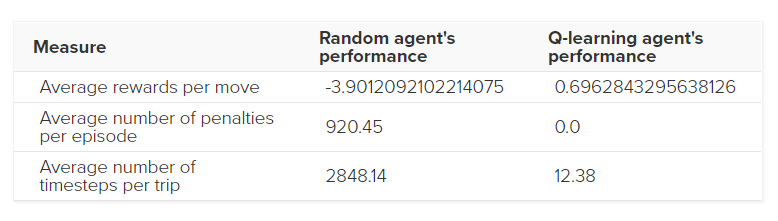

In [22]:
from IPython.display import Image
Image("img/q_learning_compare.png",width=600)

#### Hyperparameters and optimizations
Learn about it on: https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/